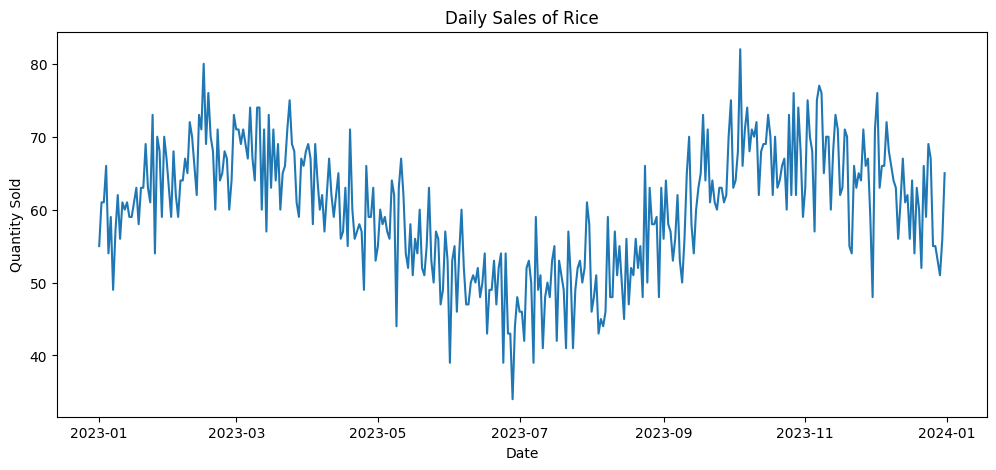

In [3]:
import pandas as pd
import numpy as np
np.random.seed(42)
dates = pd.date_range(start="2023-01-01", end="2023-12-31")
products = [
    {"id": 1, "name": "Rice"},
    {"id": 2, "name": "Oil"},
    {"id": 3, "name": "Sugar"},
    {"id": 4, "name": "Milk"},
    {"id": 5, "name": "Soap"},
]
{"id": 1, "name": "Rice"}
data = []
for product in products:
    base_demand = np.random.randint(20, 60)
    seasonal_pattern = 10*np.sin(np.linspace(0, 3*np.pi, len(dates)))
    noise = np.random.normal(0, 5, len(dates))
    sales = base_demand + seasonal_pattern + noise
    sales = np.round(sales)
    for i in range(len(dates)):
        data.append([
            dates[i],
            product["id"],
            product["name"],
            max(0, int(sales[i])),
            np.random.randint(200, 600)
        ])
df = pd.DataFrame(data, columns=[
    "date", "product_id", "product_name",
    "quantity_sold", "current_stock"
])
df.head(10)
df.tail(10)

import matplotlib.pyplot as plt

rice = df[df["product_name"] == "Rice"]

plt.figure(figsize=(12,5))
plt.plot(rice["date"], rice["quantity_sold"])
plt.title("Daily Sales of Rice")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.show()




In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


In [5]:
rice_rf = rice[["date", "quantity_sold"]].copy()

# Create memory features
rice_rf["lag_1"] = rice_rf["quantity_sold"].shift(1)
rice_rf["lag_7"] = rice_rf["quantity_sold"].shift(7)
rice_rf["lag_30"] = rice_rf["quantity_sold"].shift(30)

# Remove rows where lag values are NaN
rice_rf = rice_rf.dropna()

rice_rf.head()


,date,quantity_sold,lag_1,lag_7,lag_30
30,2023-01-31,63,67.0,73.0,55.0
31,2023-02-01,59,63.0,54.0,61.0
32,2023-02-02,68,59.0,70.0,61.0
33,2023-02-03,62,68.0,68.0,66.0
34,2023-02-04,59,62.0,59.0,54.0


In [6]:
X = rice_rf[["lag_1", "lag_7", "lag_30"]]
y = rice_rf["quantity_sold"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [7]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [8]:
y_pred = model_rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", round(mae, 2))


Mean Absolute Error: 5.82


In [9]:
future_predictions = []

lag_1 = rice_rf["quantity_sold"].iloc[-1]
lag_7 = rice_rf["quantity_sold"].iloc[-7]
lag_30 = rice_rf["quantity_sold"].iloc[-30]

for i in range(30):
    
    X_future = pd.DataFrame(
        [[lag_1, lag_7, lag_30]],
        columns=["lag_1", "lag_7", "lag_30"]
    )
    
    next_pred = model_rf.predict(X_future)[0]
    future_predictions.append(next_pred)
    
    # Update lags
    lag_30 = lag_7
    lag_7 = lag_1
    lag_1 = next_pred


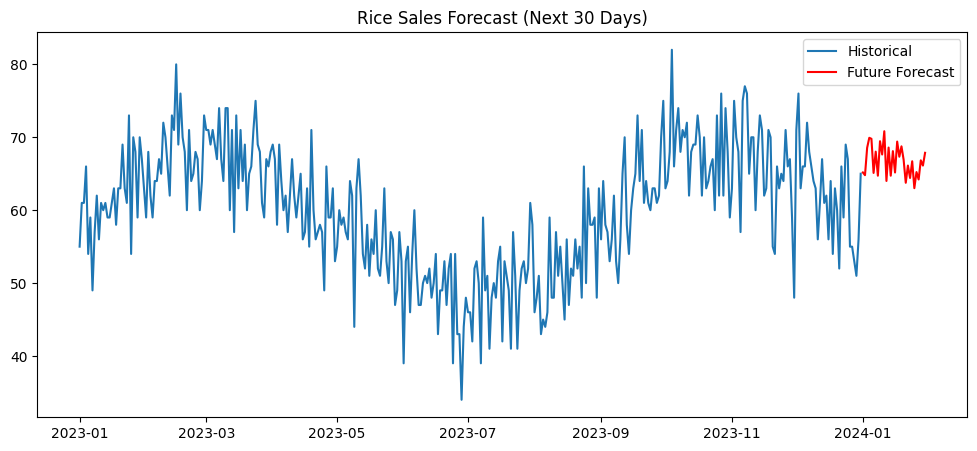

In [10]:
plt.figure(figsize=(12,5))

plt.plot(rice["date"], rice["quantity_sold"], label="Historical")

future_dates = pd.date_range(
    start=rice["date"].iloc[-1] + pd.Timedelta(days=1),
    periods=30
)

plt.plot(future_dates, future_predictions, label="Future Forecast", color="red")

plt.legend()
plt.title("Rice Sales Forecast (Next 30 Days)")
plt.show()


In [11]:
avg_demand = rice["quantity_sold"].mean()

lead_time = 7
safety_stock = 0.2 * avg_demand

reorder_point = (avg_demand * lead_time) + safety_stock
current_stock = rice["current_stock"].iloc[-1]

print("Average Daily Demand:", round(avg_demand))
print("Reorder Point:", round(reorder_point))
print("Current Stock:", current_stock)

if current_stock < reorder_point:
    print("⚠️ Reorder Needed")
else:
    print("Stock Level Safe")


Average Daily Demand: 60
Reorder Point: 432
Current Stock: 225
⚠️ Reorder Needed


In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

results = {}

products = df["product_name"].unique()

for product in products:
    
    print("\n==============================")
    print("Product:", product)
    
    product_df = df[df["product_name"] == product].copy()
    
    # Create time index (trend feature)
    product_df["time_index"] = range(len(product_df))
    
    # Create seasonality features
    product_df["day_of_week"] = product_df["date"].dt.dayofweek
    product_df["month"] = product_df["date"].dt.month
    
    # Create lag features
    product_df["lag_1"] = product_df["quantity_sold"].shift(1)
    product_df["lag_2"] = product_df["quantity_sold"].shift(2)
    product_df["lag_3"] = product_df["quantity_sold"].shift(3)
    product_df["lag_7"] = product_df["quantity_sold"].shift(7)
    product_df["lag_14"] = product_df["quantity_sold"].shift(14)
    product_df["lag_30"] = product_df["quantity_sold"].shift(30)
    
    product_df = product_df.dropna()
    
    features = [
        "lag_1", "lag_2", "lag_3",
        "lag_7", "lag_14", "lag_30",
        "day_of_week", "month",
        "time_index"
    ]
    
    X = product_df[features]
    y = product_df["quantity_sold"]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )
    
    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    
    print("MAE:", round(mae, 2))
    
    # Inventory logic
    avg_demand = product_df["quantity_sold"].mean()
    lead_time = 7
    safety_stock = 0.2 * avg_demand
    
    reorder_point = (avg_demand * lead_time) + safety_stock
    current_stock = product_df["current_stock"].iloc[-1]
    
    if current_stock < reorder_point:
        reorder_status = "Reorder Needed"
    else:
        reorder_status = "Stock Safe"
    
    print("Reorder Point:", round(reorder_point))
    print("Current Stock:", current_stock)
    print("Status:", reorder_status)
    
    results[product] = {
        "MAE": round(mae, 2),
        "Reorder Point": round(reorder_point),
        "Current Stock": current_stock,
        "Status": reorder_status
    }



Product: Rice
MAE: 5.67
Reorder Point: 431
Current Stock: 225
Status: Reorder Needed

Product: Oil
MAE: 5.92
Reorder Point: 185
Current Stock: 511
Status: Stock Safe

Product: Sugar
MAE: 4.46
Reorder Point: 354
Current Stock: 409
Status: Stock Safe

Product: Milk
MAE: 4.55
Reorder Point: 298
Current Stock: 427
Status: Stock Safe

Product: Soap
MAE: 5.07
Reorder Point: 219
Current Stock: 537
Status: Stock Safe


In [13]:
def validate_and_clean_csv(file_path):
    
    required_columns = [
        "date",
        "product_name",
        "quantity_sold",
        "current_stock"
    ]
    
    try:
        df = pd.read_csv(file_path)
    except Exception as e:
        return None, f"Error reading file: {e}"
    
    # Check required columns
    missing_cols = [col for col in required_columns if col not in df.columns]
    if missing_cols:
        return None, f"Missing required columns: {missing_cols}"
    
    # Convert date
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    if df["date"].isnull().any():
        return None, "Invalid date format detected."
    
    # Convert numeric columns
    df["quantity_sold"] = pd.to_numeric(df["quantity_sold"], errors="coerce")
    df["current_stock"] = pd.to_numeric(df["current_stock"], errors="coerce")
    
    if df[["quantity_sold", "current_stock"]].isnull().any().any():
        return None, "Invalid numeric values detected."
    
    # Minimum data check per product
    for product in df["product_name"].unique():
        if len(df[df["product_name"] == product]) < 45:
            return None, f"Not enough data for product: {product} (Minimum 45 days required)"
    
    return df, "File validated successfully"


In [14]:
df.to_csv("test_upload.csv", index=False)
print("Test CSV saved successfully")


Test CSV saved successfully


In [15]:
validated_df, message = validate_and_clean_csv("test_upload.csv")
print(message)


File validated successfully


In [16]:
bad_df = df.drop(columns=["current_stock"])
bad_df.to_csv("bad_upload.csv", index=False)

validated_df, message = validate_and_clean_csv("bad_upload.csv")
print(message)


Missing required columns: ['current_stock']


In [19]:
def run_forecasting_pipeline(df):
    
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_absolute_error
    
    results = {}
    
    products = df["product_name"].unique()
    
    for product in products:
        
        product_df = df[df["product_name"] == product].copy()
        
        # Feature engineering
        product_df["time_index"] = range(len(product_df))
        product_df["day_of_week"] = product_df["date"].dt.dayofweek
        product_df["month"] = product_df["date"].dt.month
        
        product_df["lag_1"] = product_df["quantity_sold"].shift(1)
        product_df["lag_2"] = product_df["quantity_sold"].shift(2)
        product_df["lag_3"] = product_df["quantity_sold"].shift(3)
        product_df["lag_7"] = product_df["quantity_sold"].shift(7)
        product_df["lag_14"] = product_df["quantity_sold"].shift(14)
        product_df["lag_30"] = product_df["quantity_sold"].shift(30)
        
        product_df = product_df.dropna()
        
        features = [
            "lag_1", "lag_2", "lag_3",
            "lag_7", "lag_14", "lag_30",
            "day_of_week", "month",
            "time_index"
        ]
        
        X = product_df[features]
        y = product_df["quantity_sold"]
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, shuffle=False
        )
        
        model = RandomForestRegressor(n_estimators=200, random_state=42)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        
        # Inventory logic
        avg_demand = product_df["quantity_sold"].mean()
        lead_time = 7
        safety_stock = 0.2 * avg_demand
        
        reorder_point = (avg_demand * lead_time) + safety_stock
        current_stock = int(product_df["current_stock"].iloc[-1])

        
        if current_stock < reorder_point:
            reorder_status = "Reorder Needed"
        else:
            reorder_status = "Stock Safe"
        
        results[product] = {
            "MAE": round(mae, 2),
            "Reorder Point": int(round(reorder_point))
,
            "Current Stock": current_stock,
            "Status": reorder_status
        }
    
    return results


In [20]:
results = run_forecasting_pipeline(df)
results


{'Rice': {'MAE': 5.67,
  'Reorder Point': 431,
  'Current Stock': 225,
  'Status': 'Reorder Needed'},
 'Oil': {'MAE': 5.92,
  'Reorder Point': 185,
  'Current Stock': 511,
  'Status': 'Stock Safe'},
 'Sugar': {'MAE': 4.46,
  'Reorder Point': 354,
  'Current Stock': 409,
  'Status': 'Stock Safe'},
 'Milk': {'MAE': 4.55,
  'Reorder Point': 298,
  'Current Stock': 427,
  'Status': 'Stock Safe'},
 'Soap': {'MAE': 5.07,
  'Reorder Point': 219,
  'Current Stock': 537,
  'Status': 'Stock Safe'}}